In [301]:
import re
import ast
import json
from graphviz import Digraph

benchmark = 'b4c31708_9ebe'

cfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.colors'
task_style = {}
with open(cfile, 'r') as cfd:
    raw = cfd.read().split('\n')
    for ln in raw:
        if not ln: 
            continue
        task_name, actual = ln.split(',')
        if task_name not in task_style:
            task_style[task_name] = {}
        task_style[task_name]['actual'] = actual    

cfile = f'/local0/serverless-sim/results/{benchmark}.simcolors'
with open(cfile, 'r') as cfd:
    raw = cfd.read().split('\n')
    for ln in raw:
        if not ln: 
            continue
        task_name, simulator = ln.split(',')
        if task_name not in task_style:
            task_style[task_name] = {}
        task_style[task_name]['simulator'] = simulator 
        
        
for t in task_style:
    print(t, task_style[t])
    




execute_point_no_scratch-13dadb4b-0835-49f0-b4eb-2751f7894805 {'actual': '1', 'simulator': '1'}
join-4c8d9c64-54ec-4a2a-869e-11a7ea4d50e9 {'actual': '1', 'simulator': '1'}
execute_point_no_scratch-f6f8cba7-ee78-4a2b-b67e-f1f2d6876b0e {'actual': '2', 'simulator': '3'}
execute_point_no_scratch-6a7f63cd-06d5-4d77-abc3-cd2685d0c9c1 {'actual': '2', 'simulator': '4'}
execute_point_no_scratch-2ba7d2bf-27a1-46c2-9a76-7f84ebed803b {'actual': '2', 'simulator': '3'}
execute_point_no_scratch-f2879804-9568-4880-84f8-a8db9cb2e5ae {'actual': '2', 'simulator': '4'}
execute_point_no_scratch-60a9b3c4-c0de-4dca-a89c-85c508c3ae46 {'actual': '3', 'simulator': '2'}
execute_point_no_scratch-2d774873-8f7d-4fd7-8f69-a196f0555da7 {'actual': '3', 'simulator': '2'}
execute_point_no_scratch-4c6005f4-c7af-47c2-a14d-77bdbc6bb4ce {'actual': '3', 'simulator': '4'}
execute_point_no_scratch-c3964cc4-72b5-4207-b6d8-6c60b4b334c3 {'actual': '3', 'simulator': '3'}
execute_point_no_scratch-503fb350-9601-4315-a6b6-915e3d46ab7

In [308]:
jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'

with open(jfile, 'r') as fd:
    stats = ast.literal_eval(fd.read())
    for s in stats:
        print(s, stats[s].keys())
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        for ss in startsstops:
            print(ss)
        print('\n\n')

execute_point_no_scratch-f6f8cba7-ee78-4a2b-b67e-f1f2d6876b0e dict_keys(['worker', 'msg'])
{'action': 'compute', 'start': 1618582747.9293838, 'stop': 1618582747.9307055}



execute_point_no_scratch-60a9b3c4-c0de-4dca-a89c-85c508c3ae46 dict_keys(['worker', 'msg'])
{'action': 'compute', 'start': 1618582747.9305193, 'stop': 1618582747.932207}



execute_point_no_scratch-13dadb4b-0835-49f0-b4eb-2751f7894805 dict_keys(['worker', 'msg'])
{'action': 'compute', 'start': 1618582747.9299927, 'stop': 1618582747.931696}



execute_point_no_scratch-503fb350-9601-4315-a6b6-915e3d46ab79 dict_keys(['worker', 'msg'])
{'action': 'compute', 'start': 1618582747.931862, 'stop': 1618582747.9338884}



execute_point_no_scratch-75b0b844-3eed-4ae6-b6f4-30f11b30b6f0 dict_keys(['worker', 'msg'])
{'action': 'transfer', 'start': 1618582747.9416218, 'stop': 1618582747.9563537, 'source': 'tcp://10.255.23.108:44233', 'nbytes': 1048576}
{'action': 'transfer', 'start': 1618582747.9413939, 'stop': 1618582747.9573264, 's

In [302]:
# color the graph
import graph_tool.all as gt
import copy
import matplotlib.colors as mcolors

css_colors = list(mcolors.CSS4_COLORS.keys())


gfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.g'



with open(gfile, 'r') as fd:
    raw = fd.read().split('\n')
    g = gt.Graph(directed=True)
    vid_to_vx = {}
    name_to_vid = {}
    
    g.vertex_properties['name'] = g.new_vertex_property("string")
    g.vertex_properties['color'] = g.new_vertex_property("string")
    g.vertex_properties['icolor'] = g.new_vertex_property("int")
    g.vertex_properties['simcolor'] = g.new_vertex_property("string")
    g.vertex_properties['isimcolor'] = g.new_vertex_property("string")
    for ln in raw:
        if ln.startswith('v'):
            _, vid, name = ln.split(',', 2)
            v = g.add_vertex()
            vid_to_vx[vid] = v
            name_to_vid[name] = vid
            
            g.vp.name[v] = name
            try:
                g.vp.color[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['actual'])]]
                g.vp.icolor[v] = int(task_style[name]['actual'])
                g.vp.simcolor[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['simulator'])]]
                g.vp.isimcolor[v] = int(task_style[name]['simulator'])
            #print(name, g.vp.icolor[v])
            except KeyError:
                g.vp.color[v] = 'yellow'
                g.vp.icolor[v] = 2
                
    for ln in raw:        
        if ln.startswith('e'):
            _, vsrc, vdst, _ = ln.split(',', 3)
            g.add_edge(vid_to_vx[vsrc], vid_to_vx[vdst])

In [305]:
dg = Digraph('G', filename=f'{benchmark}.gv', format='png')
for v in g.vertices():
    dg.attr('node', shape='ellipse', style='filled', color=g.vp.color[v])
    dg.node(f'{v}, color({g.vp.icolor[v]})')
    
for e in g.edges():
    dg.edge(f'{e.source()}, color({g.vp.icolor[e.source()]})', 
            f'{e.target()}, color({g.vp.icolor[e.target()]})')
    

dg.view(f'{benchmark}', quiet=False)

dg = Digraph('G', filename=f'{benchmark}.simulator.gv', format='png')
for v in g.vertices():
    dg.attr('node', shape='ellipse', style='filled', color=g.vp.simcolor[v])
    dg.node(f'{v}, color({g.vp.isimcolor[v]})')
    
for e in g.edges():
    dg.edge(f'{e.source()}, color({g.vp.isimcolor[e.source()]})', 
            f'{e.target()}, color({g.vp.isimcolor[e.target()]})')
    

dg.view(f'{benchmark}.simulator', quiet=False)

'b4c31708_9ebe.simulator.png'

In [285]:
fanins = []
for v in g.vertices():
    if v.in_degree() > 1:
        fanins.append(v)

workers = {}
stops = []
for fin_v in fanins:
    for vin in fin_v.in_neighbors():
        wrkr = stats[g.vp.name[vin]]['worker'].split(':')[1].replace('//', '')
        task_stat = stats[g.vp.name[vin]]['msg']
        for op in task_stat['startstops']:
            if op['action'] == 'compute':
                stops.append(op['stop'])
                
        if wrkr not in workers:
            workers[wrkr] = 0
        workers[wrkr] += 1;    
print(max(stops), min(stops), max(stops) - min(stops))

1618582748.0191925 1618582747.9307055 0.08848690986633301


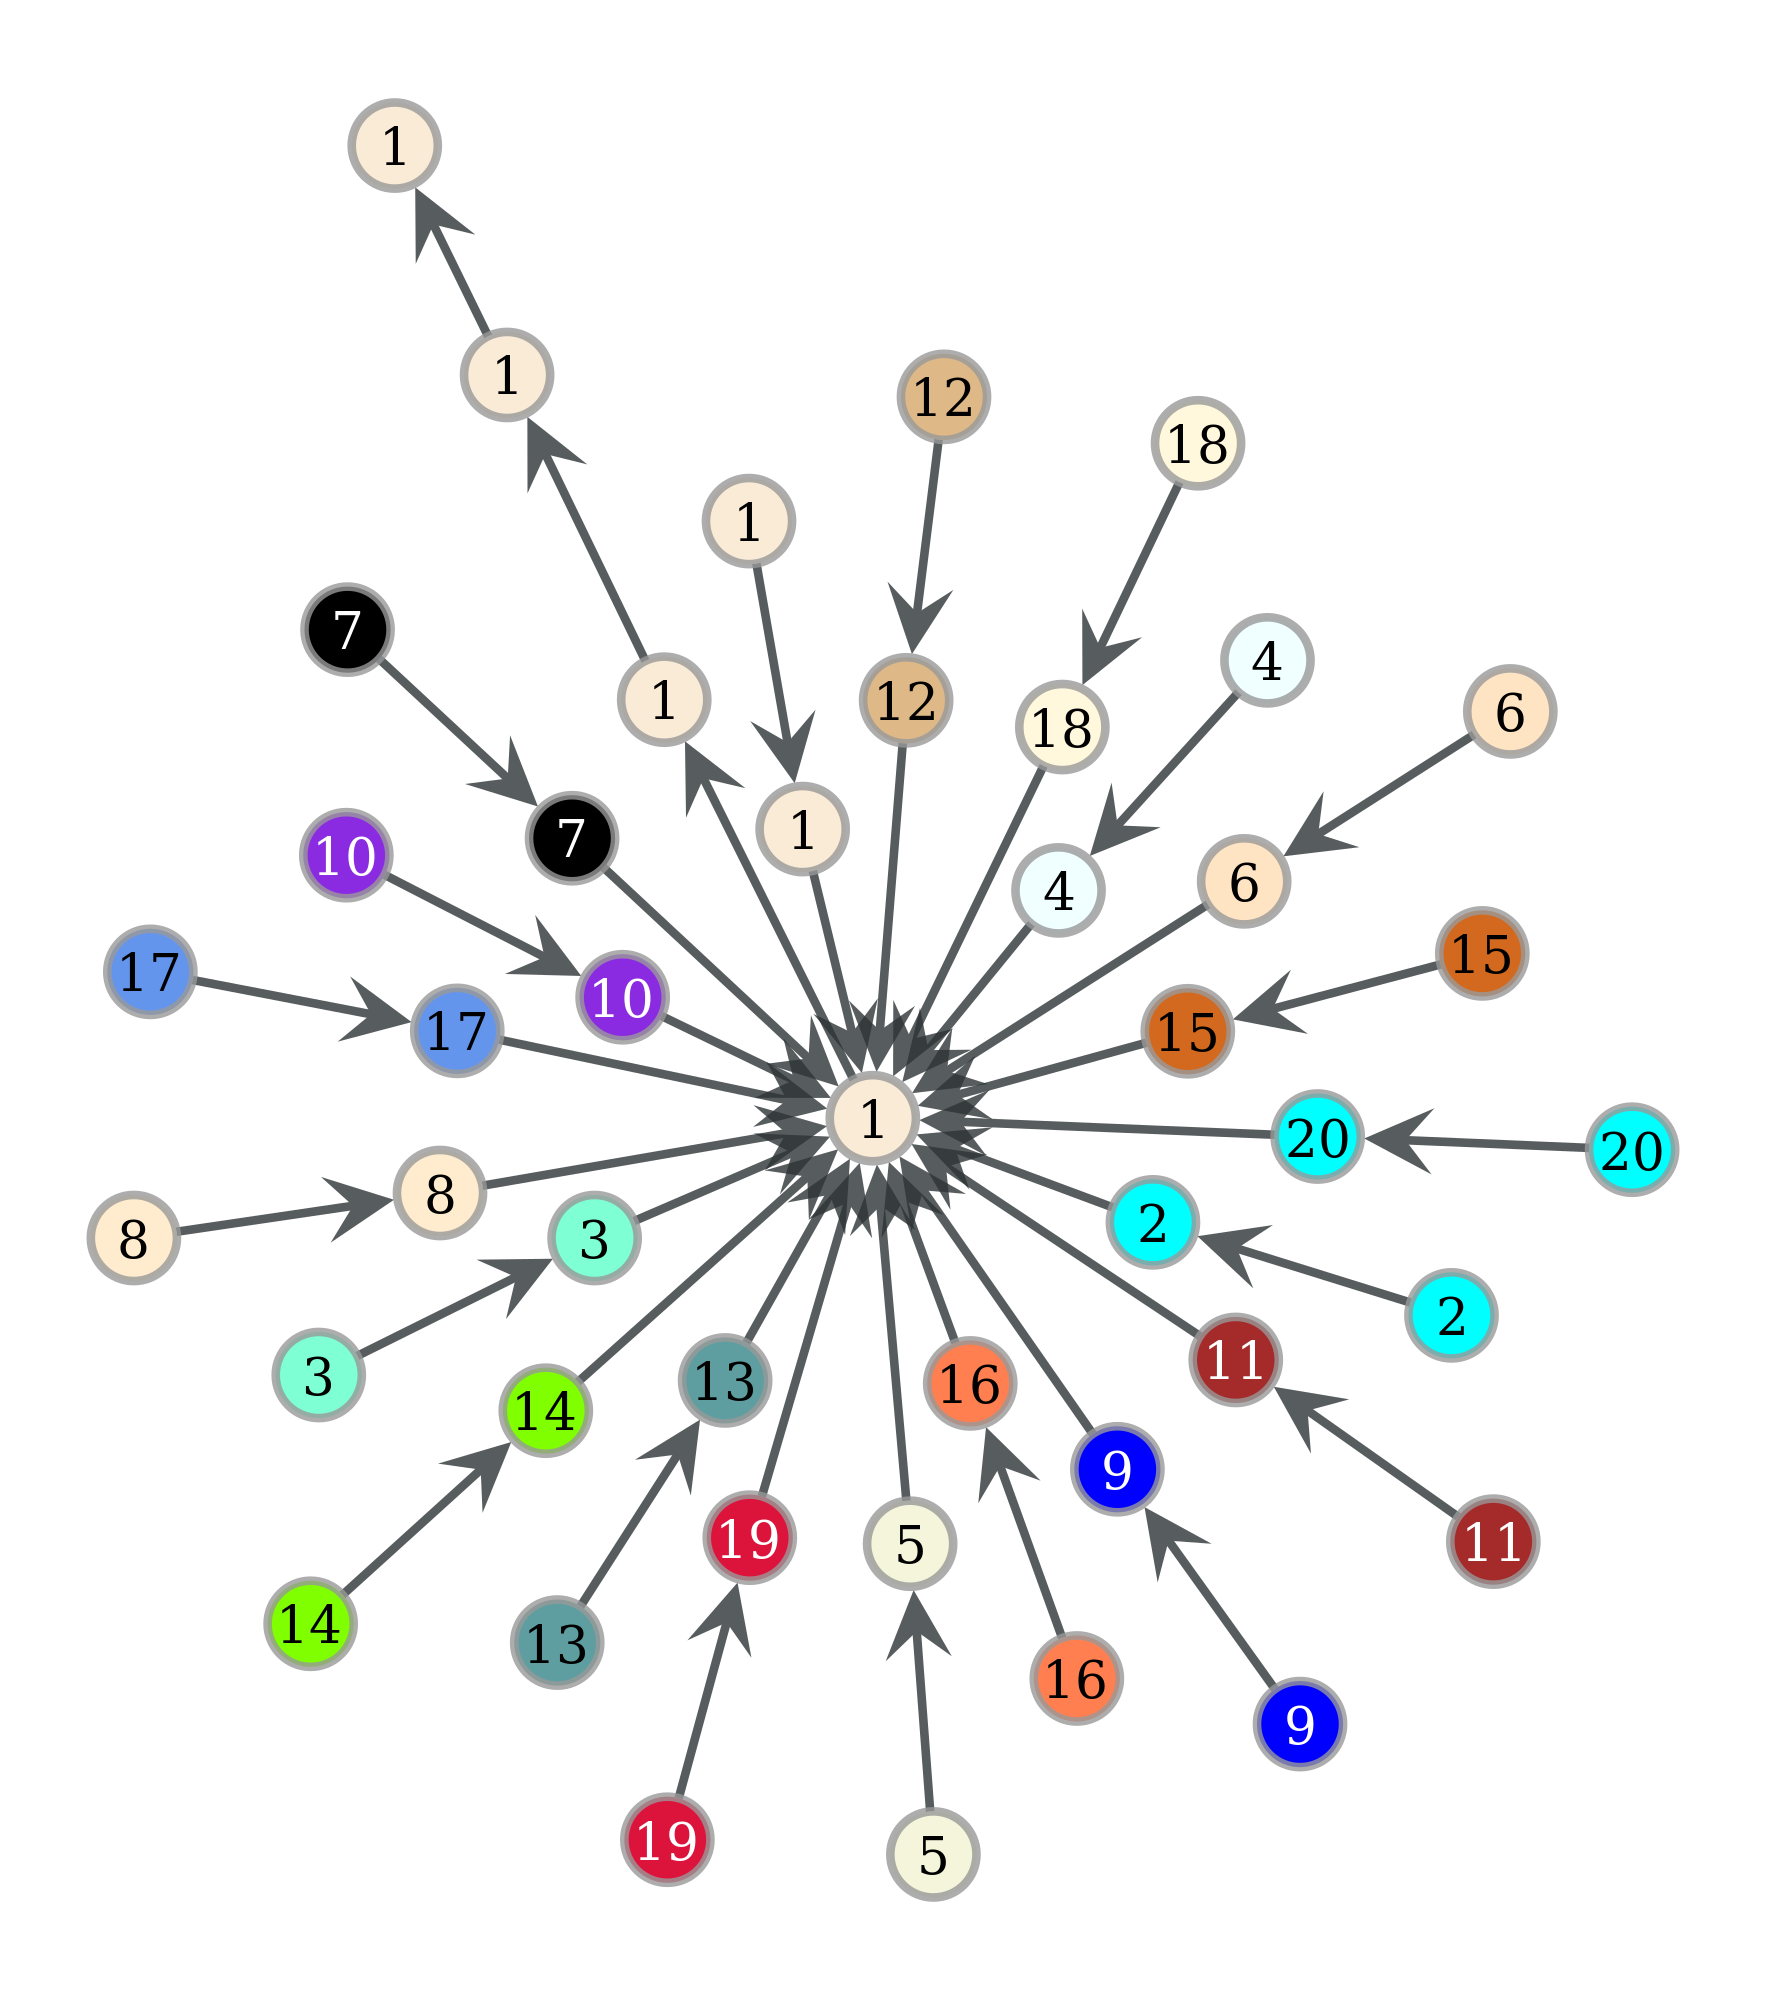

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f606c50f340, at 0x7f606c4dfca0>

In [94]:
gt.graph_draw(g, vertex_text=g.vp.isimcolor, vertex_fill_color=g.vp.simcolor, output_size = (1000, 1000))

In [320]:
gfile = f'/local0/serverless-sim/results/{benchmark}.syncwdeser.chain_color.log'

df = 
with open(gfile, 'r') as fd:
    data = ast.literal_eval(fd.read())
    for ts in data['tasks']:
        print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
    

execute_point_no_scratch-f6f8cba7-ee78-4a2b-b67e-f1f2d6876b0e 0 0.02802452876348022 192.168.1.4
execute_point_no_scratch-60a9b3c4-c0de-4dca-a89c-85c508c3ae46 0 0.02839050128240112 192.168.1.4
execute_point_no_scratch-13dadb4b-0835-49f0-b4eb-2751f7894805 0 0.02840599849004272 192.168.1.4
execute_point_no_scratch-503fb350-9601-4315-a6b6-915e3d46ab79 0 0.028729055664725337 192.168.1.3
execute_point_no_scratch-2d774873-8f7d-4fd7-8f69-a196f0555da7 0.028729055664725337 0.06391520204729298 192.168.1.4
execute_point_no_scratch-32f5c2b1-5684-469a-941d-a34daa428fa8 0.028729055664725337 0.06798438730425098 192.168.1.4
execute_point_no_scratch-6a7f63cd-06d5-4d77-abc3-cd2685d0c9c1 0.028729055664725337 0.06989700498766162 192.168.1.3
execute_point_no_scratch-75b0b844-3eed-4ae6-b6f4-30f11b30b6f0 0.028729055664725337 0.07933817806429126 192.168.1.3
execute_point_no_scratch-4c6005f4-c7af-47c2-a14d-77bdbc6bb4ce 0.07933817806429126 0.11799816919857459 192.168.1.3
execute_point_no_scratch-9e620ef0-9a97-49

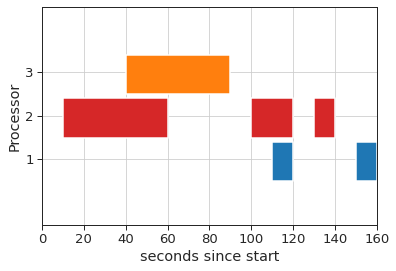

In [316]:
# Importing the matplotlb.pyplot
import matplotlib.pyplot as plt
  
# Declaring a figure "gnt"
fig, ax = plt.subplots()
  
# Setting Y-axis limits
ax.set_ylim(0, 50)
  
# Setting X-axis limits
ax.set_xlim(0, 160)
  
# Setting labels for x-axis and y-axis
ax.set_xlabel('seconds since start')
ax.set_ylabel('Processor')
  
# Setting ticks on y-axis
ax.set_yticks([15, 25, 35])
# Labelling tickes of y-axis
ax.set_yticklabels(['1', '2', '3'])
  
# Setting graph attribute
ax.grid(True)
  
# Declaring a bar in schedule
ax.broken_barh([(40, 50)], (30, 9), facecolors =('tab:orange'))
  
# Declaring multiple bars in at same level and same width
ax.broken_barh([(110, 10), (150, 10)], (10, 9),
                         facecolors ='tab:blue')
  
ax.broken_barh([(10, 50), (100, 20), (130, 10)], (20, 9),
                                  facecolors =('tab:red'))
  
#plt.savefig("gantt1.png")